**Описание проекта**

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В ходе работы над проектом я постараюсь выявить закономерности, позволяющие определить успешность игр.
Для этого я определю средний срок жизни разных платформ, а также актуальные на данный момент платформы. Составлю портрет пользователя в разных регионах мира. 
В моём распоряжение есть датасет с данными о продаже игр до 2016г со следующими столбцами:

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [167]:
#импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

In [168]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [169]:
#импортируем данные
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    print('Ошибка. Проверьте правильность пути к данным')

<font size="4">Подготовка данных:</font>

In [170]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN
5,Tetris,GB,"1,989.00",Puzzle,23.20,2.26,4.22,0.58,nan,NaN,NaN
6,New Super Mario Bros.,DS,"2,006.00",Platform,11.28,9.14,6.50,2.88,89.00,8.5,E
7,Wii Play,Wii,"2,006.00",Misc,13.96,9.18,2.93,2.84,58.00,6.6,E
8,New Super Mario Bros. Wii,Wii,"2,009.00",Platform,14.44,6.94,4.70,2.24,87.00,8.4,E
9,Duck Hunt,NES,"1,984.00",Shooter,26.93,0.63,0.28,0.47,nan,NaN,NaN


In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [172]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,"16,446.00","16,715.00","16,715.00","16,715.00","16,715.00","8,137.00"
mean,"2,006.48",0.26,0.15,0.08,0.05,68.97
std,5.88,0.81,0.50,0.31,0.19,13.94
min,"1,980.00",0.00,0.00,0.00,0.00,13.00
25%,"2,003.00",0.00,0.00,0.00,0.00,60.00
50%,"2,007.00",0.08,0.02,0.00,0.01,71.00
75%,"2,010.00",0.24,0.11,0.04,0.03,79.00
max,"2,016.00",41.36,28.96,10.22,10.57,98.00


In [173]:
data.describe(include=[object])

,Name,Platform,Genre,User_Score,Rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


In [174]:
#Посмотрим проценты пропущенных значений по столбцам
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
Name,0.01
Platform,0
Year_of_Release,1.61
Genre,0.01
NA_sales,0
EU_sales,0
JP_sales,0
Other_sales,0
Critic_Score,51.32
User_Score,40.09


Вывод: Много пропусков в данных о рейтингах. Оставлю эти данные как есть, замена такого объема на медианы исказит картину.
Значение tbd в User_Score значит, что у игры пока нет рейтинга и он будет определен позднее. Для нас это значит, что сейчас такие значения можно прировнять к пропускам. 
Ещё есть небольшой процент пропусков в Year_of_Release, но их я просто удалю

In [175]:
#Приведем название столбцов в нижний регистр
data.columns = data.columns.str.lower()

In [176]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN


In [177]:
#Заменю пропущенные значения в year_of_release к 0, чтобы можно было привести тип данных к целочисленному.
data['year_of_release'] = data['year_of_release'].fillna(0).astype('int')

In [178]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN


In [179]:
# приравняем tbd к nan в user_score
data.loc[data['user_score'] == 'tbd','user_score'] = np.nan
data['user_score'] = data['user_score'].astype('float')

In [180]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,nan,nan,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,nan,nan,NaN


In [181]:
#посчитаем сумму продаж по всем ренионам для каждой игры
data['sales_sum'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [182]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,nan,nan,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,nan,nan,NaN,31.38


<font size="4">Исследовательский анализ данных:</font>

Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

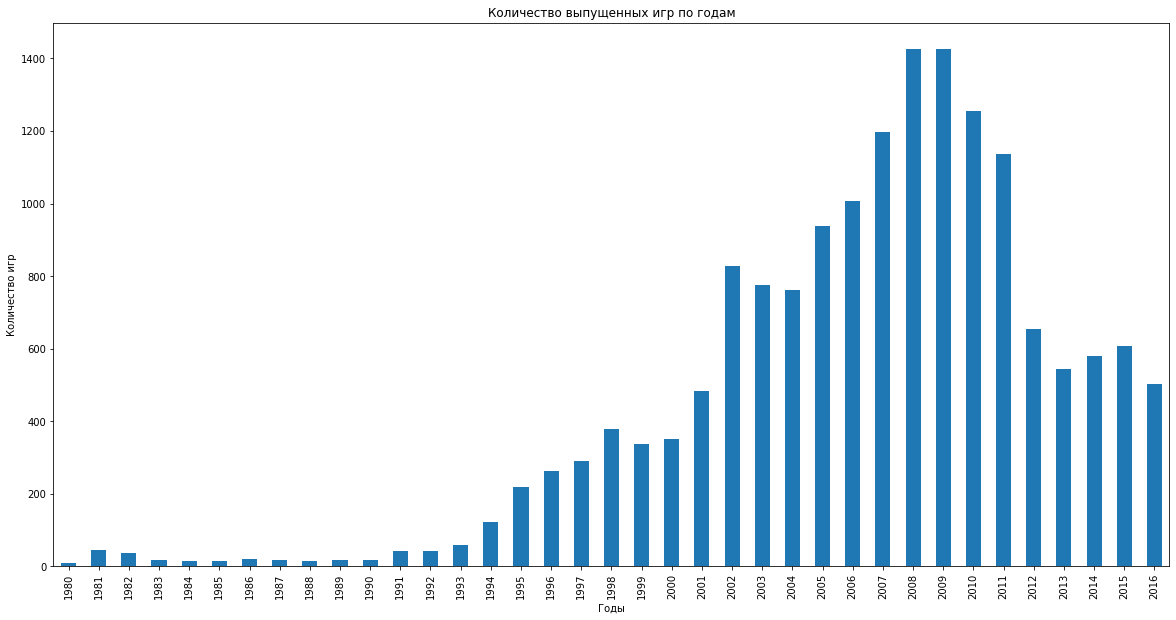

In [183]:
#Создадим сводную таблицу игр количества игр по годам.  
games_year_pivot_table = data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
games_year_pivot_table = games_year_pivot_table.query('year_of_release != 0' )
games_year_pivot_table.columns = ['games_count']
games_year_pivot_table.plot(y = 'games_count', kind = 'bar', figsize = (20,10), legend=None) 
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Годы')
plt.ylabel('Количество игр')
plt.show()

По графику видно, что данные за все годы нам не нужны. В 1980-90гг выпускалось очень небольшое количество игр и платформ, на которых они выпускались уже давно не существует. А быстрый рост количества игр начинается с 2001 года, поэтому я буду использовать этот временной период. Пик выпуска игр приходится на 2008-2009г. потом идёт резкий спад. Скорее всего это всязано с мировым экономическим кризисом 2008г и его последствиями.

In [184]:
#Определим платформы с наибольшими суммарными продажами
top_platforms_2001_2016 = (data
    .query('2001 <= year_of_release <= 2016')
    .groupby('platform')
    .agg({'sales_sum':['sum']})
    .sort_values(by=('sales_sum', 'sum'), ascending=False)
    .head(15)
)
top_platforms_2001_2016.columns = ['sales_sum_platf']
top_platforms_2001_2016

,sales_sum_platf
platform,
PS2,"1,194.39"
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS4,314.14
GBA,312.81
PSP,289.53
3DS,257.81


In [185]:
#Чтобы построить график продаж по года, посчитаем суммарный доход каждой платформы по годам.
platforms_years = (data
    .query('platform in @top_platforms_2001_2016.index and 2001 <= year_of_release <= 2016')
    .groupby(['platform', 'year_of_release'])
    .agg({'sales_sum':['sum']})
)
platforms_years.columns = ['sales_sum_platf']

In [186]:
#сброшу индексы, чтобы можно было построить barplot для всег платформ по годам
platforms_years = platforms_years.reset_index()

In [187]:
platforms_years.head()

,platform,year_of_release,sales_sum_platf
0,3DS,2011,63.20
1,3DS,2012,51.36
2,3DS,2013,56.57
3,3DS,2014,43.76
4,3DS,2015,27.78


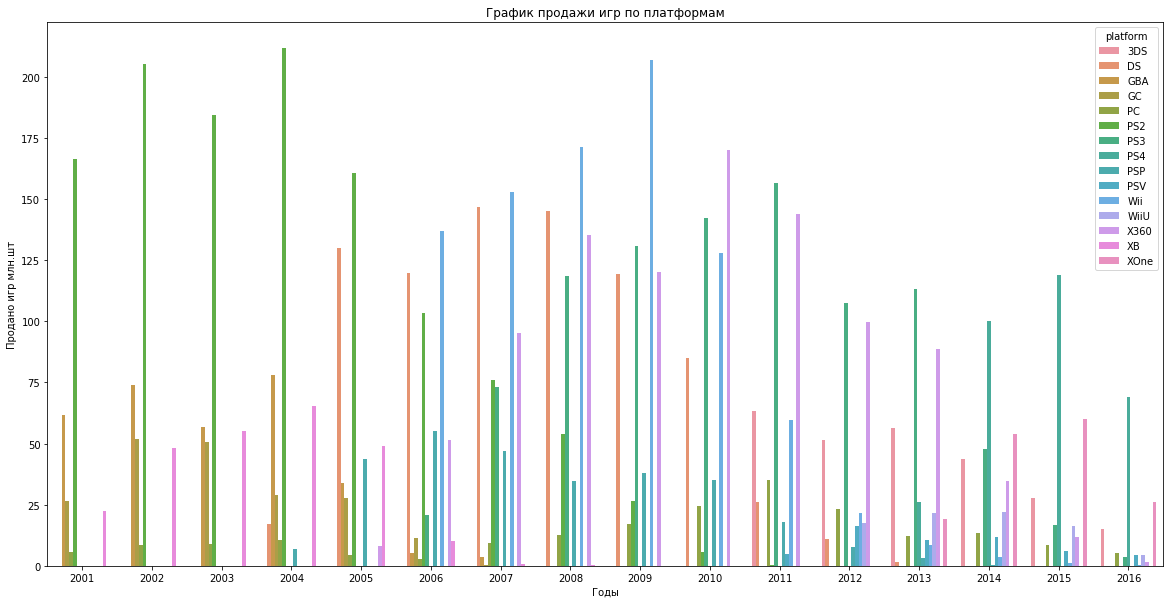

In [188]:
plt.figure(figsize=(20, 10))
sns.barplot(x='year_of_release', y='sales_sum_platf', hue='platform', data=platforms_years)
plt.title('График продажи игр по платформам')
plt.xlabel('Годы')
plt.ylabel('Продано игр млн.шт')
plt.show()

<font size="3">Срок жизни платформ</font>

In [189]:
platforms_years_top = (data
    .query('platform in @top_platforms_2001_2016.index and 2001 <= year_of_release <= 2016')
    .groupby(['platform', 'year_of_release'])
    .agg({'sales_sum':['sum']})
)
platforms_years_top.columns = ['sales_sum_platf']

In [190]:

platforms_years_top.droplevel(level=1).index.value_counts().mean()

8.666666666666666

Средний срок жизни платформы около 9 лет. 

Видно аномально большое снижение продаж в 2016г. Скорее всего это связано с тем, что данные за 2016г не полные(такое предупреждение есть в условии проекта). Поэтому я ещё раз уточню актуальный период и все дальнейшие расчёты буду вести для интервала с 2007 по 2015г.

In [191]:
top_platforms_2007_2015 = (data
    .query('2007 <= year_of_release <= 2015')
    .groupby('platform')
    .agg({'sales_sum':['sum']})
    .sort_values(by=('sales_sum', 'sum'), ascending=False)
    .head(15)
)
top_platforms_2007_2015.columns = ['sales_sum_platf']
top_platforms_2007_2015

,sales_sum_platf
platform,
PS3,906.78
X360,899.85
Wii,753.85
DS,535.54
PS4,244.89
3DS,242.67
PSP,183.31
PS2,162.38
PC,155.32


Ещё раз определим популярность платформ  период с 2007 по 2015г.

In [192]:
platforms_years_2007_2015 = (data
    .query('platform in @top_platforms_2007_2015.index and 2007 <= year_of_release <= 2015')
    .groupby(['platform', 'year_of_release'])
    .agg({'sales_sum':['sum']})
)
platforms_years_2007_2015.columns = ['sales_sum_platf']

In [193]:
platforms_years_2007_2015 = platforms_years_2007_2015.reset_index()

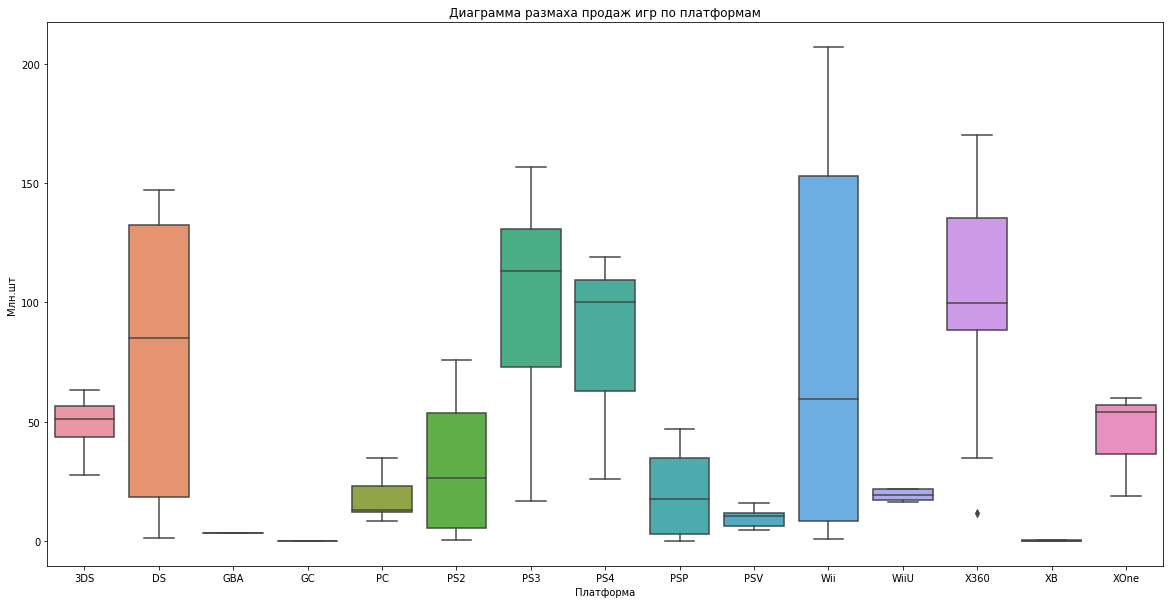

In [194]:
#Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам
plt.figure(figsize=(20, 10))
sns.boxplot(x='platform', y='sales_sum_platf', data=platforms_years_2007_2015)
plt.title('Диаграмма размаха продаж игр по платформам')
plt.ylabel('Млн.шт')
plt.xlabel('Платформа')
plt.show()

In [195]:
platforms_years_2007_2015 = (data
    .query('2007 <= year_of_release <= 2015 and platform in @top_platforms_2007_2015.index')
    .pivot_table(index='platform', columns='year_of_release', values='sales_sum',aggfunc='sum')
)
platforms_years_2007_2015

year_of_release,2007,2008,2009,2010,2011,2012,2013,2014,2015
platform,,,,,,,,,
3DS,nan,nan,nan,nan,63.20,51.36,56.57,43.76,27.78
DS,146.94,145.31,119.54,85.02,26.18,11.01,1.54,nan,nan
GBA,3.40,nan,nan,nan,nan,nan,nan,nan,nan
GC,0.27,nan,nan,nan,nan,nan,nan,nan,nan
PC,9.28,12.42,16.91,24.28,35.03,23.22,12.38,13.28,8.52
PS2,75.99,53.90,26.40,5.64,0.45,nan,nan,nan,nan
PS3,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82
PS4,nan,nan,nan,nan,nan,nan,25.99,100.00,118.90
PSP,46.93,34.55,37.78,35.04,17.82,7.69,3.14,0.24,0.12


Вывод: Продажи большинства платформ падают к 2015г. У части это связано с концом жизненого цикла самой платформы, у других с общим уменьшением рынка компьютерных игр. 

Рост к 1015 году показывают только две платформы PS4 и XOne. Поэтому только их я могу назвать перспективными.

Неплохие продажи всё ещё показывают WiiU и 3DS, но скорее это относится к Япончкому рынку.  

<font size="3">Посмотрим, на примере самой популярной (на момент выгрузки данных) платформы PS4, как влияют на продажи отзывы критиков и пользователей.</font>

In [196]:
#Сделаем копию среза исходного датафрейма в период с 2007 по 2015г. 
data_2007_2015 = (data
    .query('2007 <= year_of_release <= 2015 and platform in @top_platforms_2007_2015.index')
    .copy()
)     
data_2007_2015.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.00,8.40,E,28.32
13,Wii Fit,Wii,2007,Sports,8.92,8.03,3.60,2.15,80.00,7.70,E,22.70
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.00,6.30,E,21.82
15,Wii Fit Plus,Wii,2009,Sports,9.01,8.49,2.53,1.77,80.00,7.40,E,21.80
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.00,8.20,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.00,8.10,M,16.27
27,Pokemon Black/Pokemon White,DS,2010,Role-Playing,5.51,3.17,5.65,0.80,nan,nan,NaN,15.13
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.00,3.40,M,14.73


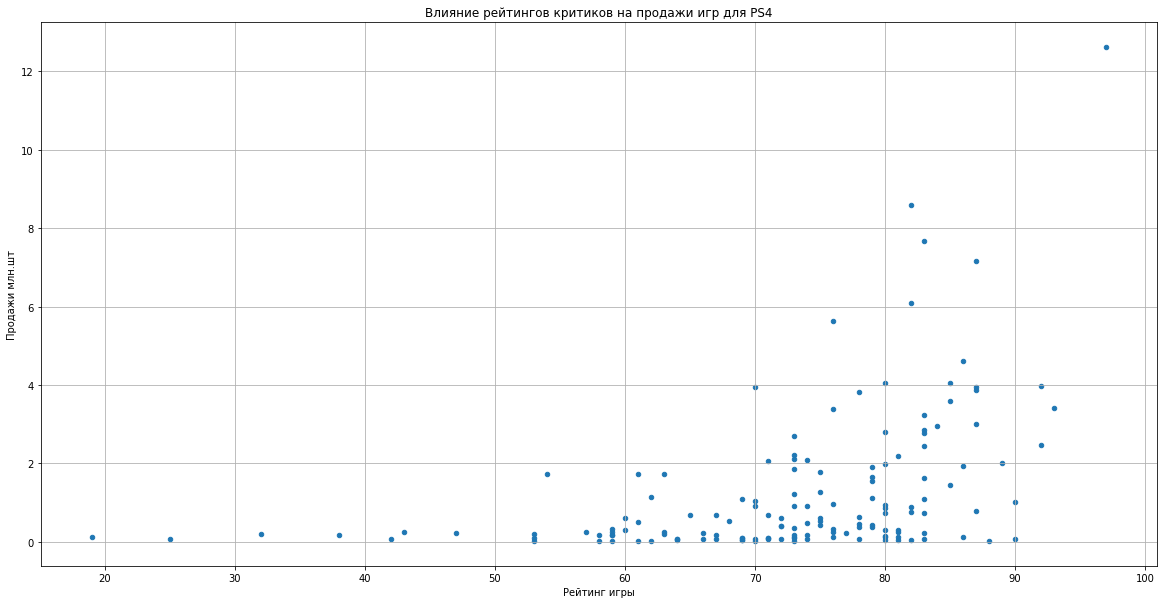

In [197]:
#построим диаграмму рассеяния отзывов критиков для платформы PS4
(data_2007_2015
    .query('platform == "PS4"')
    .dropna()
    .plot(y='sales_sum', x='critic_score', kind = 'scatter',legend=True, grid=True, figsize=(20, 10))
)
plt.title('Влияние рейтингов критиков на продажи игр для PS4')
plt.ylabel('Продажи млн.шт')
plt.xlabel('Рейтинг игры')
plt.show()

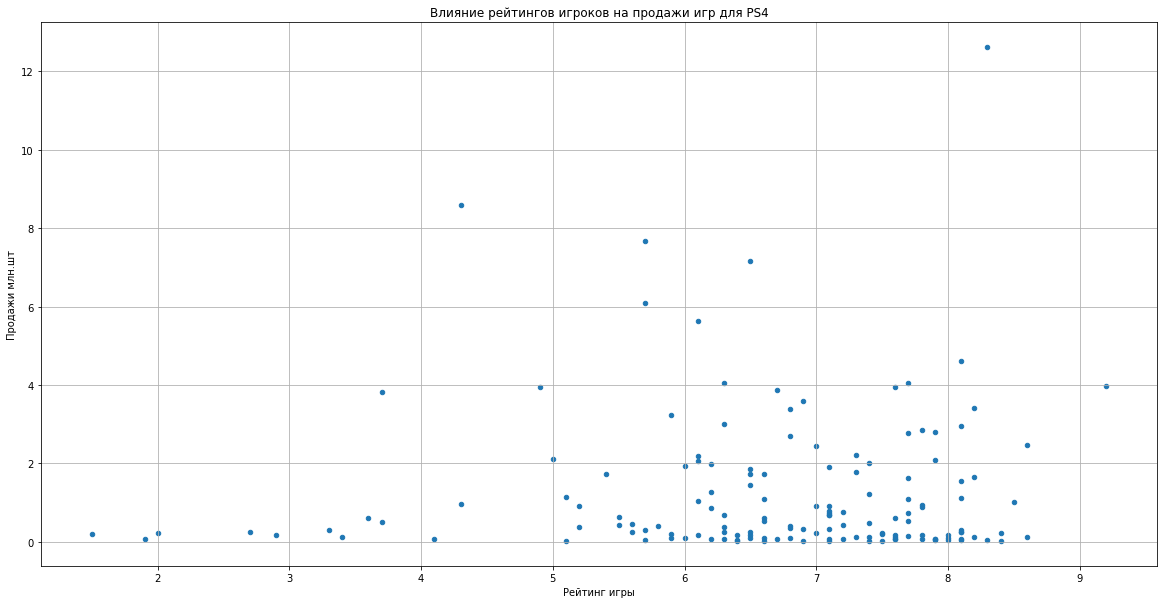

In [198]:
#построим диаграмму рассеяния отзывов пользователей для платформы PS4
(data_2007_2015
    .query('platform == "PS4"')
    .dropna()
    .plot(y='sales_sum', x='user_score', kind = 'scatter',legend=True, grid=True, figsize=(20, 10))
)
plt.title('Влияние рейтингов игроков на продажи игр для PS4')
plt.ylabel('Продажи млн.шт')
plt.xlabel('Рейтинг игры')
plt.show()

In [199]:
ps4_critic = data_2007_2015.query('platform == "PS4"')['critic_score'].dropna()
ps4_user = data_2007_2015.query('platform == "PS4"')['user_score'].dropna()
ps4_sales_sum = data_2007_2015.query('platform == "PS4"')['sales_sum']

Посчитаем коэффициент корреляции между отзывами критиков и пользователей и суммами продаж игр на PS4

In [200]:
print(ps4_critic.corr(ps4_sales_sum))
print(ps4_user.corr(ps4_sales_sum))

0.4318482049982005
0.024230832360622557


Вывод: Продажи игр больше зависят от рейтинга критиков, чем от рейтинга пользователей. Это видно на графиках и это же подтверждают значения коэффициентов корреляции.

<font size="3">Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?</font>

In [201]:
#Сгруппируем игры по жанрам. Посчитаем сумму продаж и количество игр каждого жанра.
genre_pivot_table = (data_2007_2015
    .groupby('genre')
    .agg({'sales_sum':['sum', 'count', 'mean']})
    .sort_values(by=('sales_sum', 'sum'), ascending=False)
)
genre_pivot_table.columns = ['sales_sum', 'count', 'mean']

In [202]:
genre_pivot_table.head(10)

,sales_sum,count,mean
genre,,,
Action,"1,020.48",2020,0.51
Shooter,640.56,620,1.03
Sports,634.58,1076,0.59
Misc,485.29,1113,0.44
Role-Playing,446.85,832,0.54
Racing,262.40,463,0.57
Platform,227.22,271,0.84
Simulation,197.24,531,0.37
Fighting,161.53,342,0.47


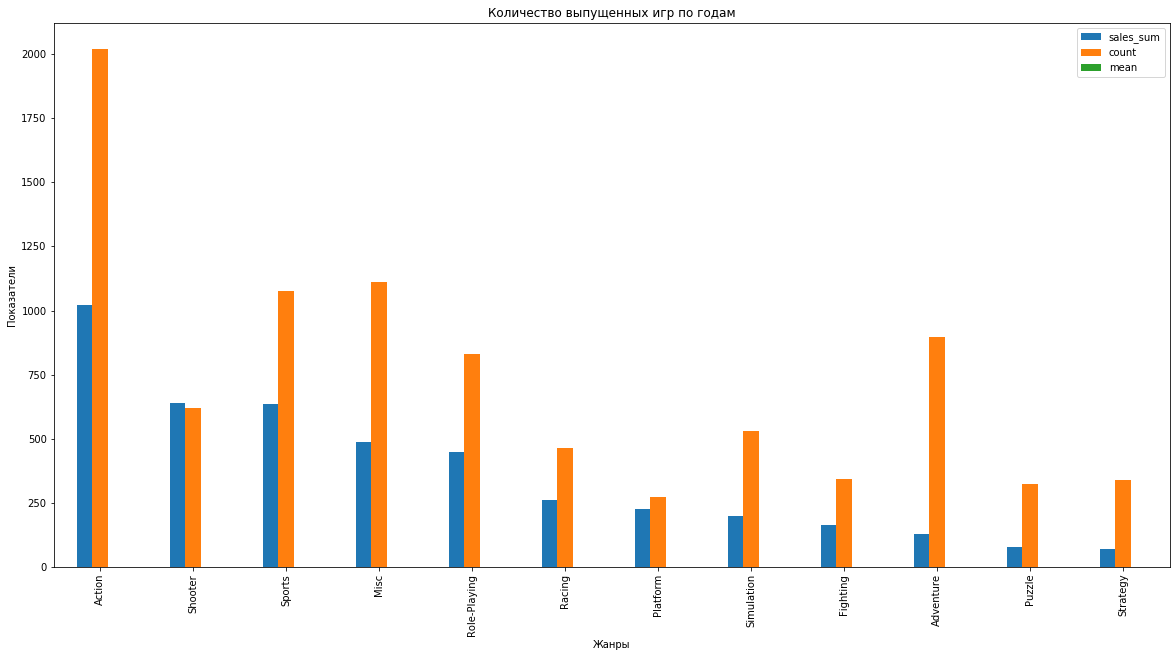

In [203]:
genre_pivot_table.plot(kind = 'bar', figsize = (20,10), legend = ('сумма продаж', 'количество игр')) 
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Жанры')
plt.ylabel('Показатели')
plt.show()

Самым популярным жанром является Action, в нем появляется больше всего игр и он же приносит больше всего прибыли. Интересно, что в жанре Adventure тоже выходит достаточно много игр, но ини приносят гораздо меньше денег.

<font size="4">Составим портрет пользователя каждого региона:</font>

Определим самые популярные платформы для регионов(NA, EU, JP):

In [204]:
#Создадим сводную таблицу топ5 платформ по продажам в Северной Америке
na_sales_top5_pivot_table = (data_2007_2015
    .pivot_table(index = 'platform', values = ['na_sales'], aggfunc = ['sum'])
    .sort_values(by=('sum', 'na_sales'), ascending=False)
    .head(5)
)
na_sales_top5_pivot_table.columns = ['na_sales']

In [205]:
#Создадим сводную таблицу топ5 платформ по продажам в Европе
eu_sales_top5_pivot_table = (data_2007_2015
    .pivot_table(index = 'platform', values = ['eu_sales'], aggfunc = ['sum'])
    .sort_values(by=('sum', 'eu_sales'), ascending=False)
    .head(5)
)
eu_sales_top5_pivot_table.columns = ['eu_sales']

In [206]:
#Создадим сводную таблицу топ5 платформ по продажам в Японии
jp_sales_top5_pivot_table = (data_2007_2015
    .pivot_table(index = 'platform', values = ['jp_sales'], aggfunc = ['sum'])
    .sort_values(by=('sum', 'jp_sales'), ascending=False)
    .head(5)
)
jp_sales_top5_pivot_table.columns = ['jp_sales']

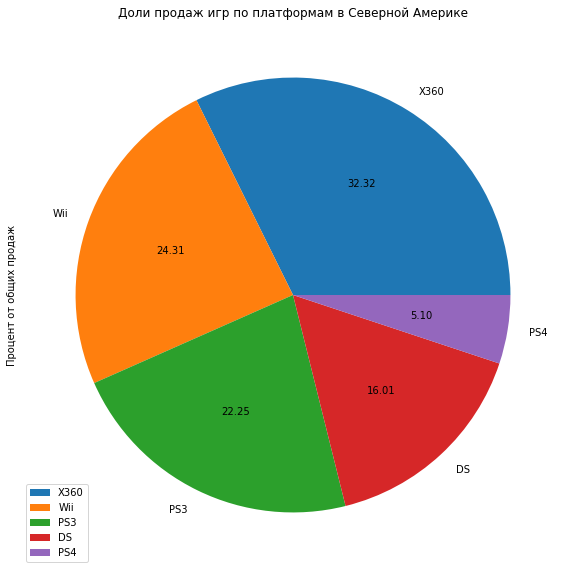

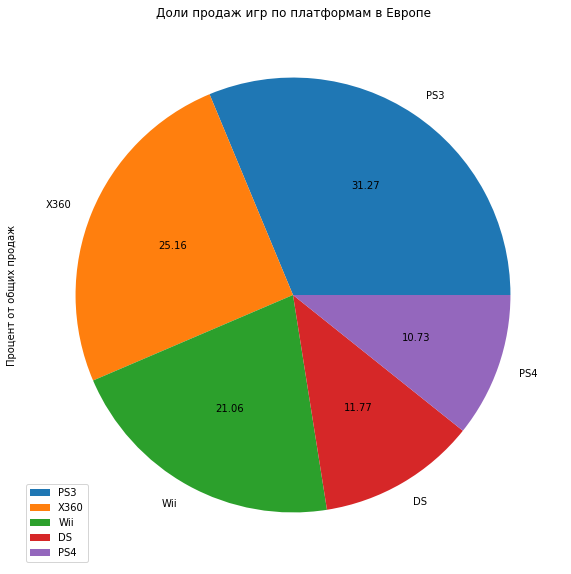

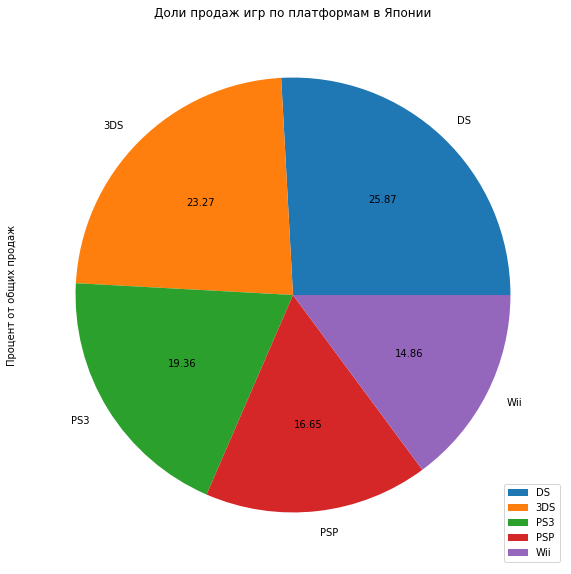

In [207]:
na_sales_top5_pivot_table.plot(kind='pie', autopct='%1.2f', figsize =(10,10), legend = True, subplots=True)
plt.title('Доли продаж игр по платформам в Северной Америке')
plt.ylabel('Процент от общих продаж')
plt.show()
eu_sales_top5_pivot_table.plot(kind='pie', autopct='%1.2f', figsize =(10,10), legend = True, subplots=True)
plt.title('Доли продаж игр по платформам в Европе')
plt.ylabel('Процент от общих продаж')
plt.show()
jp_sales_top5_pivot_table.plot(kind='pie', autopct='%1.2f', figsize =(10,10), legend = True, subplots=True)
plt.title('Доли продаж игр по платформам в Японии')
plt.ylabel('Процент от общих продаж')
plt.show()

Вывод: Предпочтения игроков в разных частях света различаются. И если в Северной Америке и Европе  предпочтения игроков очень похожи и большая часть рынка поделена между тремя платформами PS3, X360 и Wii. То в Японии, доминирует другие платформы: DS и 3DS.

Определим самые популярные жанры для регионов(NA, EU, JP):

In [208]:
na_top5_genre = (data_2007_2015
    .pivot_table(index = 'genre', values = ['na_sales'], aggfunc = ['sum'])
    .sort_values(by=('sum', 'na_sales'), ascending=False)
    .head(5)
)
na_top5_genre.columns = ['na_genre_sum']

In [209]:
eu_top5_genre = (data_2007_2015
    .pivot_table(index = 'genre', values = ['eu_sales'], aggfunc = ['sum'])
    .sort_values(by=('sum', 'eu_sales'), ascending=False)
    .head(5)
)
eu_top5_genre.columns = ['eu_genre_sum']

In [210]:
jp_top5_genre = (data_2007_2015
    .pivot_table(index = 'genre', values = ['jp_sales'], aggfunc = ['sum'])
    .sort_values(by=('sum', 'jp_sales'), ascending=False)
    .head(5)
)
jp_top5_genre.columns = ['jp_genre_sum']

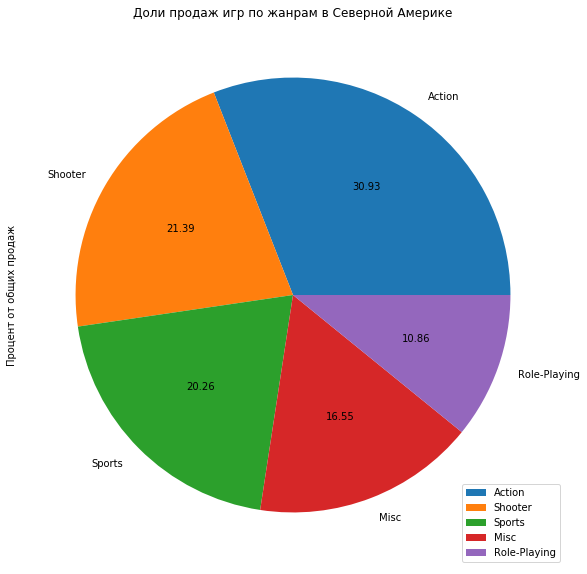

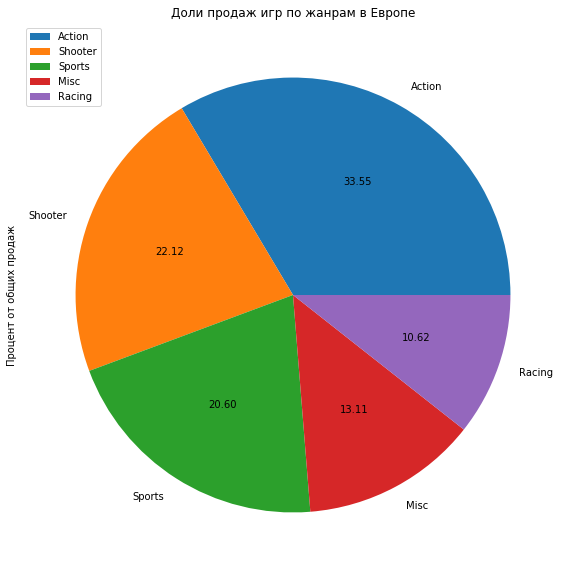

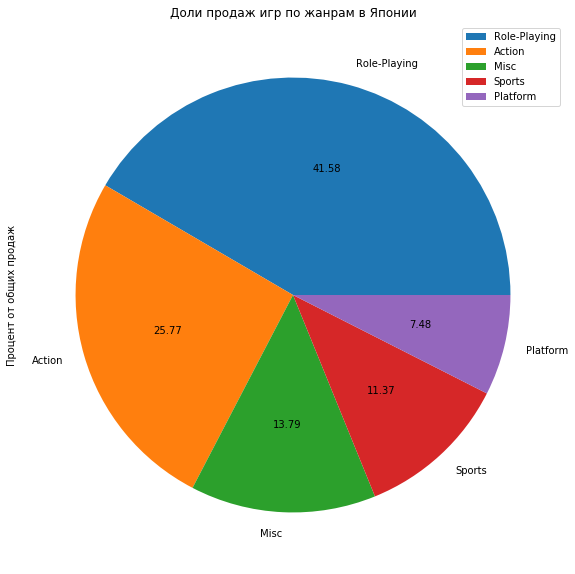

In [211]:
na_top5_genre.plot(kind='pie', autopct='%1.2f', figsize =(10,10), legend = True, subplots=True)
plt.title('Доли продаж игр по жанрам в Северной Америке')
plt.ylabel('Процент от общих продаж')
plt.show()
eu_top5_genre.plot(kind='pie', autopct='%1.2f', figsize =(10,10), legend = True, subplots=True)
plt.title('Доли продаж игр по жанрам в Европе')
plt.ylabel('Процент от общих продаж')
plt.show()
jp_top5_genre.plot(kind='pie', autopct='%1.2f', figsize =(10,10), legend = True, subplots=True)
plt.title('Доли продаж игр по жанрам в Японии')
plt.ylabel('Процент от общих продаж')
plt.show()

Вывод: Предпочтения игроков в Северной Америке и Европе  по жанрам так же схожи. Самый популярный жанр Action. Интересно, что на пятом месте, но с примерно одинаковой долей в Америке жанр Role-Playing, а в Европе жанр Racing. 

В Японии предпочтения другие: на первом месте Role-Playing, кроме того в топе появляется Platform, которого в Европе и Америке нет вовсе.

<font size="3">Влияет ли рейтинг ESRB на продажи в отдельном регионе?:</font>

In [212]:
rating_pivot_table = data_2007_2015.pivot_table(index = ['rating'], values = ['na_sales','eu_sales','jp_sales'], aggfunc = ['sum'])
rating_pivot_table

sum                  
       eu_sales jp_sales na_sales
rating                           
E        379.47    93.99   656.02
E10+     158.94    31.46   283.80
EC         0.00     0.00     1.32
M        369.32    39.89   530.88
RP         0.03     0.00     0.00
T        208.10    72.47   362.37

Вывод: Больше всего денег во всех региона приносят игры с рейтингом E(Для всех). Скорее всего это связано с тем, в количественном выражение таких игр выпускается больше всего. Интересно что на втором месте в Америке и Европе игры с взрослым рейтингом M(17+), в которых есть насилие, нецензурная лексика и т.д. А в Японии на втором месте более миролюбивые игры с рейтингом T(13+).

<font size="4">Проверка гипотез:</font>

<font size="3">Средние пользовательские рейтинги платформ Xbox One и PC одинаковые</font>

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC различаются

In [222]:
#Сделаем срезы по платформам XOne и PC на основе пользовательских рейтингов
XOne_user_score = data_2007_2015.query('platform == "XOne"')['user_score'].dropna()

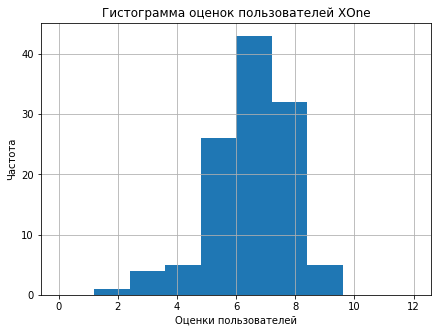

In [233]:
XOne_user_score.plot(kind = 'hist', bins = 10, grid=True, figsize = (7,5), range = (0,12), legend=None)
plt.title('Гистограмма оценок пользователей XOne')
plt.xlabel('Оценки пользователей')
plt.ylabel('Частота')
plt.show()

In [231]:
PC_user_score = data_2007_2015.query('platform == "PC"')['user_score'].dropna()

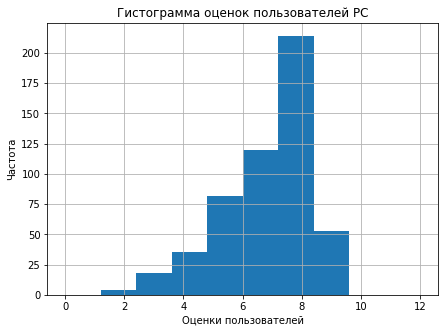

In [234]:
PC_user_score.plot(kind = 'hist', bins = 10, grid=True, figsize = (7,5), range = (0,12), legend=None)
plt.title('Гистограмма оценок пользователей PC')
plt.xlabel('Оценки пользователей')
plt.ylabel('Частота')
plt.show()

In [214]:
# сравним дисперсию выборок с помощью теста Левене
st.levene(XOne_user_score, PC_user_score, center='median', proportiontocut=0.05)

LeveneResult(statistic=3.277145322337793, pvalue=0.07071989053057912)

Результаы теста Левене говорят о том, что  дисперсия выборок не равна. Поэтому параметр equal_var=False

In [215]:
alpha = 0.05

results = st.ttest_ind(XOne_user_score, PC_user_score, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.01719689707318758
Отвергаем нулевую гипотезу


In [216]:
platform_user_score = (data_2007_2015
    .pivot_table(index = 'platform', values = ['user_score'], aggfunc = ['median'])
    .sort_values(by=('median', 'user_score'), ascending=False)
    .dropna()
)
platform_user_score

,median
,user_score
platform,
PSV,7.50
DS,7.40
PSP,7.40
PS2,7.30
PC,7.25
Wii,7.20
3DS,7.10
PS3,7.10


Вывод: Отвергаем нулевую гипотезу. Средние пользовательские рейтинги не равны. Средний рейтинг игр на PC(7.25) выше, чем средний рейтинг игр на XOne(6.70).

</font><font size="3">Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.</font>

Нулевая гипотеза: Средние пользовательские рейтинги Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.

Альтернативная гипотеза: Средние пользовательские рейтинги Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») различаются.

In [217]:
#Сделаем срезы по жанрам Action и Sports на основе пользовательских рейтингов
Action_user_score = data_2007_2015.query('genre == "Action"')['user_score'].dropna()
Sports_user_score = data_2007_2015.query('genre == "Sports"')['user_score'].dropna()

In [218]:
# сравним дисперсию выборок с помощью теста Левене
st.levene(Action_user_score, Sports_user_score, center='median', proportiontocut=0.05)

LeveneResult(statistic=22.548127133596584, pvalue=2.2236721103629547e-06)

Результаы теста Левене говорят о том, что  дисперсия выборок не равна. Поэтому параметр equal_var=False

In [219]:
alpha = 0.05

results = st.ttest_ind(Action_user_score, Sports_user_score, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")                    

p-значение: 2.3397122838684663e-09
Отвергаем нулевую гипотезу


In [220]:
platform_user_score = (data_2007_2015
    .pivot_table(index = 'genre', values = ['user_score'], aggfunc = ['median'])
    .sort_values(by=('median', 'user_score'), ascending=False)
)

In [221]:
platform_user_score.head(20)

,median
,user_score
genre,
Role-Playing,7.60
Adventure,7.50
Platform,7.40
Puzzle,7.40
Fighting,7.30
Strategy,7.20
Simulation,7.15
Action,7.10


Вывод: Отвергаем нулевую гипотезу. Средние пользовательские рейтинги жанров Action и Sports не равны. Средний рейтинг игр на Action(7.10) выше, чем средний рейтинг игр в жанре Sports(6.75).

<font size="4">Общий вывод:</font>

 В ходе исследования рынка видеоигр было выявлено, что рынок в целом падает начиная с 2009г. Скорее всего это связано не только с кризисом 2008, но и с появлением и активным развитием мобильных игр и соцсетей.

На рынке игр видна явная цикличность. Интерес к новой платформе сначала нарастает, потом достигает некоего пика, а после снижается до появления новой платфомы. И весь этот цикл продолжается около 9 лет.

Несмотря на общее падение есть платформы, продажи игр для которых увеличивается т.к они находятся в начале жизненого цикла. В первую очередь это PS4 и XOne для Северной Америке и Европы. 3DS и Wiiu для Японии. 

Кроме того было выявлено что степень успешности игр гораздо больше зависит от рейтинга критиков, чем от рейтинга пользователей.

В общем если магазин «Стримчик» хочет успешно продавать игры в Северной Америке и Европе, то это должны быть игры в жанре Action для PS4 или XOne с рейтингом ESRB E или M. А если в Японии, то это должны быть игры в жанре Role-Playing для 3DS с рейтингом ESRB E или T.